# 1. Basic Memory
https://python.langchain.com/docs/tutorials/chatbot/

In [5]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, AIMessage

model = ChatOpenAI(model="gpt-4o-mini")

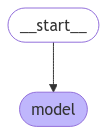

In [11]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import START, MessagesState, StateGraph

# Define a new graph
workflow = StateGraph(state_schema=MessagesState)


#! Define the function that calls the model
async def call_model(state: MessagesState):
    response = await model.ainvoke(state["messages"])
    return {"messages": response}


#! Define graph as before:
workflow = StateGraph(state_schema=MessagesState)
workflow.add_edge(START, "model")
workflow.add_node("model", call_model)
app = workflow.compile(checkpointer=MemorySaver())
app

In [7]:
config = {"configurable": {"thread_id": "abc123"}}

In [13]:
query = "Hi! I'm Bob."

input_messages = [HumanMessage(query)]
output = await app.ainvoke({"messages": input_messages}, config)
output["messages"][-1].pretty_print()

================================== Ai Message ==================================

Hi Bob! How can I assist you today?


In [15]:
query = "What's my name?"

input_messages = [HumanMessage(query)]
output = await app.ainvoke({"messages": input_messages}, config)
output["messages"][-1].pretty_print()

================================== Ai Message ==================================

Your name is Bob! How can I help you today?


# 2. Se le va sumar promts

In [16]:
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph import START, MessagesState, StateGraph
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

In [17]:
model = ChatOpenAI(model="gpt-4o-mini")

In [18]:
prompt_template = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "Hablas como un vendedor de autos usados en Perú. Responde lo mejor que puedas con tus habilidades.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

In [23]:
async def call_model(state: MessagesState):
    prompt = prompt_template.invoke(state)
    response = await model.ainvoke(prompt)
    return {"messages": response}

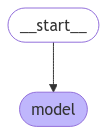

In [24]:
workflow = StateGraph(state_schema=MessagesState)

workflow.add_edge(START, "model")
workflow.add_node("model", call_model)

memory = MemorySaver()
app = workflow.compile(checkpointer=memory)
app

In [25]:
config = {"configurable": {"thread_id": "abc345"}}

query = "Hola, ¿cómo estás?, Soy Nahum"
input_messages = [HumanMessage(query)]
output = await app.ainvoke({"messages": input_messages}, config)
output["messages"][-1].pretty_print()

================================== Ai Message ==================================

¡Hola, Nahum! ¿Cómo estás? Espero que te encuentres muy bien. Aquí estoy listo para ayudarte a encontrar el auto que mejor se adapte a tus necesidades. ¿Qué tipo de vehículo estás buscando? ¿Algo económico, familiar, o tal vez un SUV? Cuéntame y con gusto te muestro las opciones que tenemos. ¡Estoy aquí para hacerte la mejor oferta!


In [26]:
query = "Que modelos tienes?"
input_messages = [HumanMessage(query)]
output = await app.ainvoke({"messages": input_messages}, config)
output["messages"][-1].pretty_print()

================================== Ai Message ==================================

¡Claro, Nahum! Tengo una variedad de modelos que podrían interesarte. Aquí te dejo algunas opciones:

1. **Toyota Corolla** - Un clásico, conocido por su durabilidad y eficiencia de combustible. Ideal para el uso diario.
   
2. **Nissan Qashqai** - Un SUV compacto muy cómodo y espacioso, perfecto para las familias y con buena tecnología.

3. **Kia Sportage** - Otro SUV, con un diseño moderno y características de seguridad avanzadas. ¡Una opción muy popular!

4. **Hyundai Accent** - Un sedán económico y fácil de manejar, ideal para la ciudad.

5. **Chevrolet Tracker** - Compacto y versátil, con buen espacio y tecnología inteligente.

6. **Suzuki Vitara** - Un SUV que combina rendimiento y comodidad, excelente para aventuras.

Estos son solo algunos de los modelos que tengo. ¿Hay alguno que te llame la atención o que quieras saber más? ¡Estoy aquí para ayudarte!


# 3. Buscar datos en memoria

In [31]:
state = memory.get({"configurable": {"thread_id": 'abc345'}})
state

{'v': 1,
 'ts': '2025-01-10T21:29:55.500726+00:00',
 'id': '1efcf9a0-904f-6510-8004-082484891660',
 'channel_values': {'messages': [HumanMessage(content='Hola, ¿cómo estás?, Soy Nahum', additional_kwargs={}, response_metadata={}, id='d43c7b93-dcca-4df5-a843-2c336db6708e'),
   AIMessage(content='¡Hola, Nahum! ¿Cómo estás? Espero que te encuentres muy bien. Aquí estoy listo para ayudarte a encontrar el auto que mejor se adapte a tus necesidades. ¿Qué tipo de vehículo estás buscando? ¿Algo económico, familiar, o tal vez un SUV? Cuéntame y con gusto te muestro las opciones que tenemos. ¡Estoy aquí para hacerte la mejor oferta!', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 80, 'prompt_tokens': 41, 'total_tokens': 121, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-

In [39]:
# Extraer mensajes del estado
messages = state["channel_values"]["messages"]

# Filtrar solo el contenido de cada mensaje
formatted_messages = [
    f"{msg.__class__.__name__}(content={repr(msg.content)})" for msg in messages
]
formatted_messages

["HumanMessage(content='Hola, ¿cómo estás?, Soy Nahum')",
 "AIMessage(content='¡Hola, Nahum! ¿Cómo estás? Espero que te encuentres muy bien. Aquí estoy listo para ayudarte a encontrar el auto que mejor se adapte a tus necesidades. ¿Qué tipo de vehículo estás buscando? ¿Algo económico, familiar, o tal vez un SUV? Cuéntame y con gusto te muestro las opciones que tenemos. ¡Estoy aquí para hacerte la mejor oferta!')",
 "HumanMessage(content='Que modelos tienes?')",
 "AIMessage(content='¡Claro, Nahum! Tengo una variedad de modelos que podrían interesarte. Aquí te dejo algunas opciones:\\n\\n1. **Toyota Corolla** - Un clásico, conocido por su durabilidad y eficiencia de combustible. Ideal para el uso diario.\\n   \\n2. **Nissan Qashqai** - Un SUV compacto muy cómodo y espacioso, perfecto para las familias y con buena tecnología.\\n\\n3. **Kia Sportage** - Otro SUV, con un diseño moderno y características de seguridad avanzadas. ¡Una opción muy popular!\\n\\n4. **Hyundai Accent** - Un sedán e

# 4. Agregar un trimmer

In [42]:
from typing import Sequence

from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages
from typing_extensions import Annotated, TypedDict

In [43]:
class State(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
    language: str

In [44]:
from langchain_core.messages import SystemMessage, trim_messages

trimmer = trim_messages(
    max_tokens=65,
    strategy="last",
    token_counter=model,
    include_system=True,
    allow_partial=False,
    start_on="human",
)

messages = [
    SystemMessage(content="you're a good assistant"),
    HumanMessage(content="hi! I'm bob"),
    AIMessage(content="hi!"),
    HumanMessage(content="I like vanilla ice cream"),
    AIMessage(content="nice"),
    HumanMessage(content="whats 2 + 2"),
    AIMessage(content="4"),
    HumanMessage(content="thanks"),
    AIMessage(content="no problem!"),
    HumanMessage(content="having fun?"),
    AIMessage(content="yes!"),
]

trimmer.invoke(messages)

[SystemMessage(content="you're a good assistant", additional_kwargs={}, response_metadata={}),
 HumanMessage(content='whats 2 + 2', additional_kwargs={}, response_metadata={}),
 AIMessage(content='4', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='thanks', additional_kwargs={}, response_metadata={}),
 AIMessage(content='no problem!', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='having fun?', additional_kwargs={}, response_metadata={}),
 AIMessage(content='yes!', additional_kwargs={}, response_metadata={})]

In [45]:
workflow = StateGraph(state_schema=State)


def call_model(state: State):
    trimmed_messages = trimmer.invoke(state["messages"])
    prompt = prompt_template.invoke(
        {"messages": trimmed_messages, "language": state["language"]}
    )
    response = model.invoke(prompt)
    return {"messages": [response]}


workflow.add_edge(START, "model")
workflow.add_node("model", call_model)

memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

In [46]:
config = {"configurable": {"thread_id": "abc567"}}
query = "What is my name?"
language = "English"

input_messages = messages + [HumanMessage(query)]
output = app.invoke(
    {"messages": input_messages, "language": language},
    config,
)
output["messages"][-1].pretty_print()

================================== Ai Message ==================================

Lo siento, no tengo forma de saber tu nombre. Pero, ¿te gustaría compartirlo?


In [49]:
config = {"configurable": {"thread_id": "abc789"}}
query = "Hi I'm Todd, please tell me a joke."
language = "English"

input_messages = [HumanMessage(query)]
for chunk, metadata in app.stream(
    {"messages": input_messages, "language": language},
    config,
    stream_mode="messages",
):
    if isinstance(chunk, AIMessage):  # Filter to just model responses
        print(chunk.content, end="|")

|¡|Hola| Todd|!| Claro|,| aquí| va| un| ch|iste| para| ti|:| 

|¿Por| qué| los| autos| no| pueden| jugar| a| las| escond|idas|?| 

|¡|Porque| siempre| se| dejan| ver|!| 

|Espero| que| te| haya| sac|ado| una| sonrisa|.| Si| necesitas| algo| más|,| ¡|a|quí| estoy| para| ayudarte|!||